# Accessing higher energy states with Qiskit Pulse

In most quantum algorithms/applications, computations are carried out over a 2-dimensional space spanned by $|0\rangle$ and $|1\rangle$. In IBM's hardware, however, there also exist higher energy states which are not typically used. The focus of this section is to explore these states using Qiskit Pulse. In particular, we demonstrate how to excite the $|2\rangle$ state and build a discriminator to classify the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states.

We recommend reviewing the prior [chapter](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html) before going through this notebook. We also suggest reading the Qiskit Pulse specifications (Ref [1](#refs)). 

### Physics Background

We now give some additional background on the physics of transmon qubits, the basis for much of IBM's quantum hardware. These systems contain superconducting circuits composed of a Josephson junction and capacitor. For those unfamiliar with superconducting circuits, see the review [here](https://arxiv.org/pdf/1904.06560.pdf) (Ref. [2](#refs)). The Hamiltonian of this system is given by

$$
H = 4 E_C n^2 - E_J \cos(\phi),
$$

where $E_C, E_J$ denote the capacitor and Josephson energies, $n$ is the reduced charge number operator and $\phi$ is the reduced flux across the junction. We work in units with $\hbar=1$.

Transmon qubits are defined in the regime where $\phi$ is small, so we may expand $E_J \cos(\phi)$ in a Taylor series (ignoring constant terms)

$$
E_J \cos(\phi) \approx \frac{1}{2} E_J \phi^2 - \frac{1}{24} E_J \phi^4 + \mathcal{O}(\phi^6).
$$

The quadratic term $\phi^2$ defines the standard harmonic oscillator. Each additional term contributes an anharmonicity.

Using the relations $n \sim (a-a^\dagger), \phi \sim (a+a^\dagger)$ (for raising, lowering operators $a^\dagger, a$), it can be shown that the system resembles a Duffing oscillator with Hamiltonian
$$
H = \omega a^\dagger a + \frac{\alpha}{2} a^\dagger a^\dagger a a,
$$

where $\omega$ gives the $0\rightarrow1$ excitation frequency ($\omega \equiv \omega^{0\rightarrow1}$) and $\alpha$ is the anharmonicity between the $0\rightarrow1$ and $1\rightarrow2$ frequencies ($\alpha \equiv \omega^{1\rightarrow2} - \omega^{0\rightarrow1}$). Drive terms can be added as needed. 

If we choose to specialize to the standard 2-dimensional subspace, we can make $|\alpha|$ sufficiently large or use special control techniques to suppress the higher energy states.

# Contents

start of the code provided by IBM (from text book)
0. [Getting started](#importing)
1. [Discriminating the 0 and 1 states](#discrim01)
    1. [0->1 Frequency Sweep](#freqsweep01)
    2. [0->1 Rabi Experiment](#rabi01)
    3. [Build the 0,1 discriminator](#builddiscrim01)
2. [Discriminating the 0, 1 and 2 states](#discrim012)
    1. [Computing the 1->2 Frequency](#freq12)
        1. [1->2 Frequency Sweep using the sideband method](#sideband12)
    2. [1->2 Rabi Experiment](#rabi12)
    3. [Build the 0, 1, 2 discriminator](#builddiscrim012)
3. [Discriminating the 0, 1, 2, and 3 states](#discrim23)
    1. [2->3 Frequency Sweep](#freq23)
    2. [2->3 Rabi Experiment](#rabi23)
    3. [Build the 2,13 discriminator](#builddiscrim23)


## 0. Getting Started <a id="importing"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform

from qiskit.tools.monitor import job_monitor

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.971855969373953 GHz.


In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [5]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

## 1. Discriminating the $|0\rangle$ and $|1\rangle$ states <a id="discrim01"></a>

### 1A. 0->1 Frequency Sweep  <a id="freqsweep01"></a>

In [7]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [8]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.3)

The frequency sweep will go from 4.951855969373953 GHz to 4.991855969373953 GHz using 75 frequencies. The drive power is 0.3.


In [9]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [10]:
print(ground_freq_sweep_job.job_id())
job_monitor(ground_freq_sweep_job)

60721baf15e37fdac41508ce
Job Status: job has successfully run


In [11]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True)

In [13]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [14]:
# do fit in Hz
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [7, 4.975*GHz, 1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

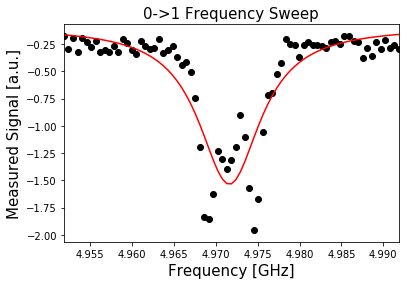

In [15]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [20]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.971856 GHz to 4.9716174 GHz.


### 1B. 0->1 Rabi Experiment <a id="rabi01"></a>

In [21]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [22]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [23]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [19]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [20]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

5f96870a834560001306fd69
Job Status: job has successfully run


In [30]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)

NameError: name 'rabi_01_job' is not defined

In [122]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

In [29]:
# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, -4, 0.5, 0])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

NameError: name 'baseline_remove' is not defined

In [24]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.22320005035637547


In [31]:
pi_amp_01 = 0.22320005035637547

In [32]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

### 1C. Build the 0,1 discriminator <a id="builddiscrim01"></a>

In [26]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

In [27]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

In [28]:
IQ_01_job = backend.run(IQ_01_program)

In [29]:
print(IQ_01_job.job_id())
job_monitor(IQ_01_job)

5f968a606167270013044513
Job Status: job has successfully run


In [30]:
# Get job data (single); split for zero and one
IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [31]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

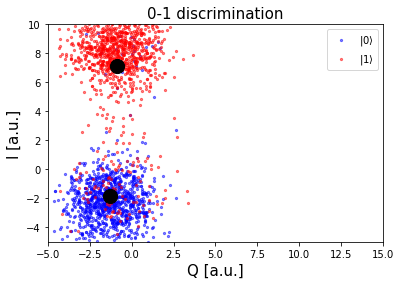

In [32]:
x_min = -5
x_max = 15
y_min = -5
y_max = 10
IQ_01_plot(x_min, x_max, y_min, y_max)

In [33]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [34]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape) # verify IQ data shape

(2048, 2)


In [35]:
# construct vector w/ 0's and 1's (for testing)
state_01 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_01 = np.concatenate((state_01, np.ones(NUM_SHOTS)))
print(len(state_01))

# Shuffle and split data into training and test sets
IQ_01_train, IQ_01_test, state_01_train, state_01_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

2048


In [36]:
# Set up the LDA
LDA_01 = LinearDiscriminantAnalysis()
LDA_01.fit(IQ_01_train, state_01_train)

LinearDiscriminantAnalysis()

In [37]:
# test on some simple data 
print(LDA_01.predict([[0,0], [10, 0]]))

[0. 0.]


In [38]:
# Compute accuracy
score_01 = LDA_01.score(IQ_01_test, state_01_test)
print(score_01)

0.939453125


The last step is to plot the separatrix. 

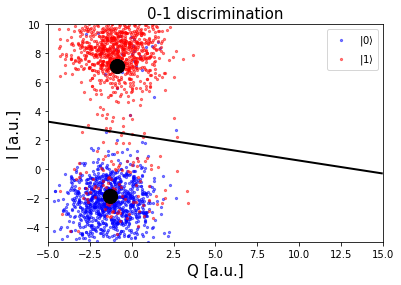

In [39]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_01, x_min, x_max, y_min, y_max, NUM_SHOTS)

We see how each side of the separatrix corresponds to a centroid (and hence a state). Given a point in the IQ plane, our model checks which side of the separatrix it lies on and returns the corresponding state. 

## 2. Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

Now that we have calibrated the $0, 1$ discriminator, we move on to exciting higher energy states. Specifically, we focus on exciting the $|2\rangle$ state and building a discriminator to classify $|0\rangle$, $|1\rangle$ and $2\rangle$ states from their respective IQ data points. The procedure for even higher states ($|3\rangle$, $|4\rangle$, etc) should be similar, but we have not tested them explicitly.

The process for building the higher state discriminator is as follows:
1. Compute the $1\rightarrow2$ frequency.
2. Conduct a Rabi experiment to obtain the $\pi$ pulse amplitude for $1\rightarrow2$. To do this, we first apply a $0\rightarrow1$ $\pi$ pulse to get from the $|0\rangle$ to the $|1\rangle$ state. Then, we do a sweep of drive amplitudes at the $1\rightarrow2$ frequency obtained above.
3. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.
4. Separate the data from each schedule into training and testing sets and construct an LDA model for discrimination.

### 2A. Computing the 1->2 frequency <a id="freq12"></a>

The first step in our calibration is to compute the frequency needed to go from the $1\rightarrow2$ state. There are two methods to do this:
1. Do a frequency sweep from the ground state and apply very high power. If the applied power is large enough, two peaks should be observed. One at the $0\rightarrow1$ frequency found in section [1](#discrim01) and one at the $0\rightarrow2$ frequency. The $1\rightarrow2$ frequency can be obtained by taking the difference of the two. Unfortunately, for `ibmq_armonk`, the maximum drive power of $1.0$ is not sufficient to see this transition. Instead, we turn to the second method.
2. Excite the $|1\rangle$ state by applying a $0\rightarrow1$ $\pi$ pulse. Then perform the frequency sweep over excitations of the $|1\rangle$ state. A single peak should be observed at a frequency lower than the $0\rightarrow1$ frequency which corresponds to the $1\rightarrow2$ frequency.

#### 1->2 Frequency Sweep using the sideband method <a id="sideband12"></a>

We follow the second method described above. To drive the $0\rightarrow 1$ $\pi$ pulse, we require a local oscillator (LO) frequency given by the calibrated $0\rightarrow1$ frequency `cal_qubit_freq` (see construction of the Rabi $\pi$ pulse in section [1](#discrim01)). To sweep the range for the $1\rightarrow2$ frequency, however, we require varying the LO frequency. Unfortunately, the Pulse specification requires a single LO frequency per schedule. 

To resolve this, we set the LO frequency to `cal_qubit_freq` and multiply a sine function onto the $1\rightarrow2$ pulse at `freq-cal_qubit_freq`, where `freq` is the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

In [25]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse    

We wrap the logic for assembling the program in a method and run our program.

In [26]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.571617405485123 GHz to 5.001617405485122 GHz using 75 frequencies. The drive power is 0.3.


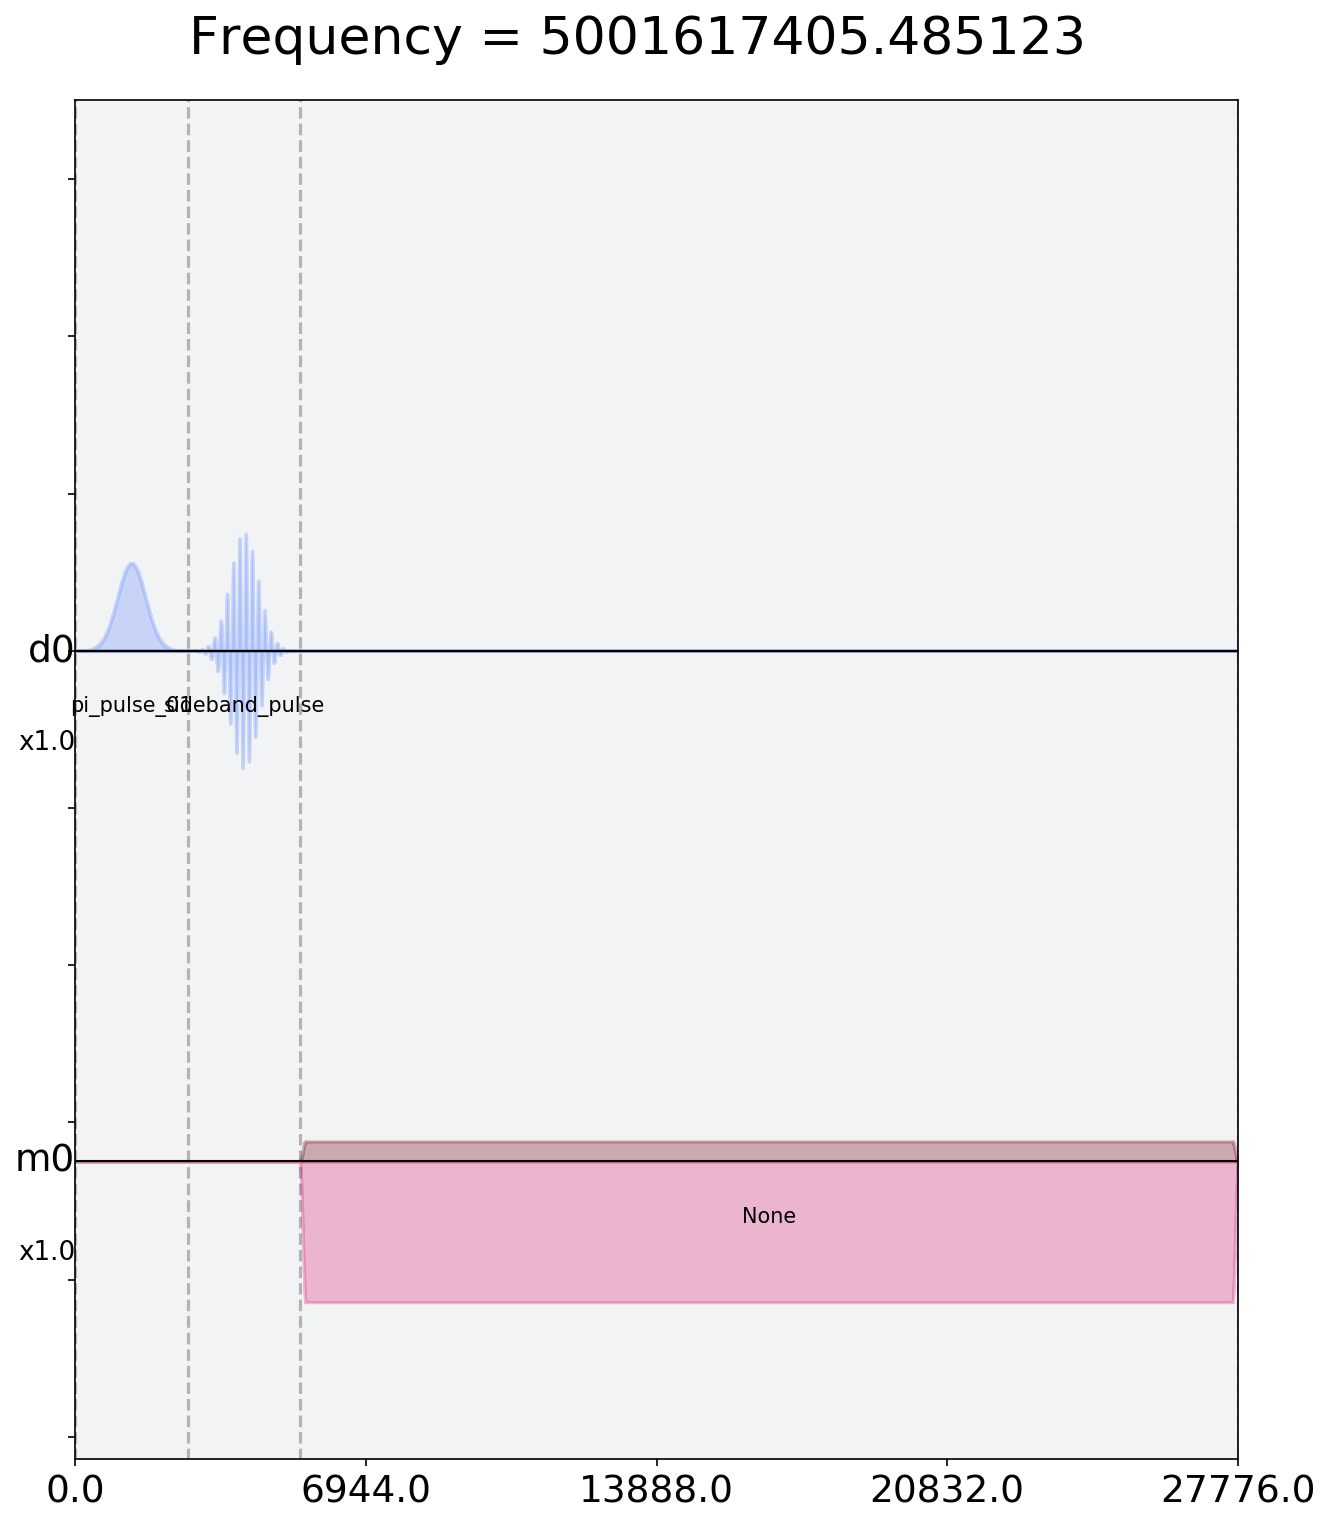

In [37]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [43]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [44]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

5f968da3183f64001367e5c7
Job Status: job has successfully run


In [45]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

In [36]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

NameError: name 'excited_freq_sweep_data' is not defined

We see a maximum around $4.64$ GHz. There are a few spurious minima, but they are too large to be the $1\rightarrow2$ frequency. The maximum corresponds the $1\rightarrow2$ frequency. 

Using a relative maxima function, we compute the value of this point exactly. This gives an estimate for the $1\rightarrow2$ frequency.

In [34]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [35]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 10)
approx_12_freq = maxima

NameError: name 'excited_freq_sweep_data' is not defined

In [56]:
approx_12_freq=4.62678631e09

We now use the estimate obtained above to do a refined sweep (ie much smaller range). This will allow us to obtain a more accurate value for the $1\rightarrow2$ frequency. We sweep $20$ MHz in each direction.

The frequency sweep will go from 4.60678631 GHz to 4.64678631 GHz using 75 frequencies. The drive power is 0.3.


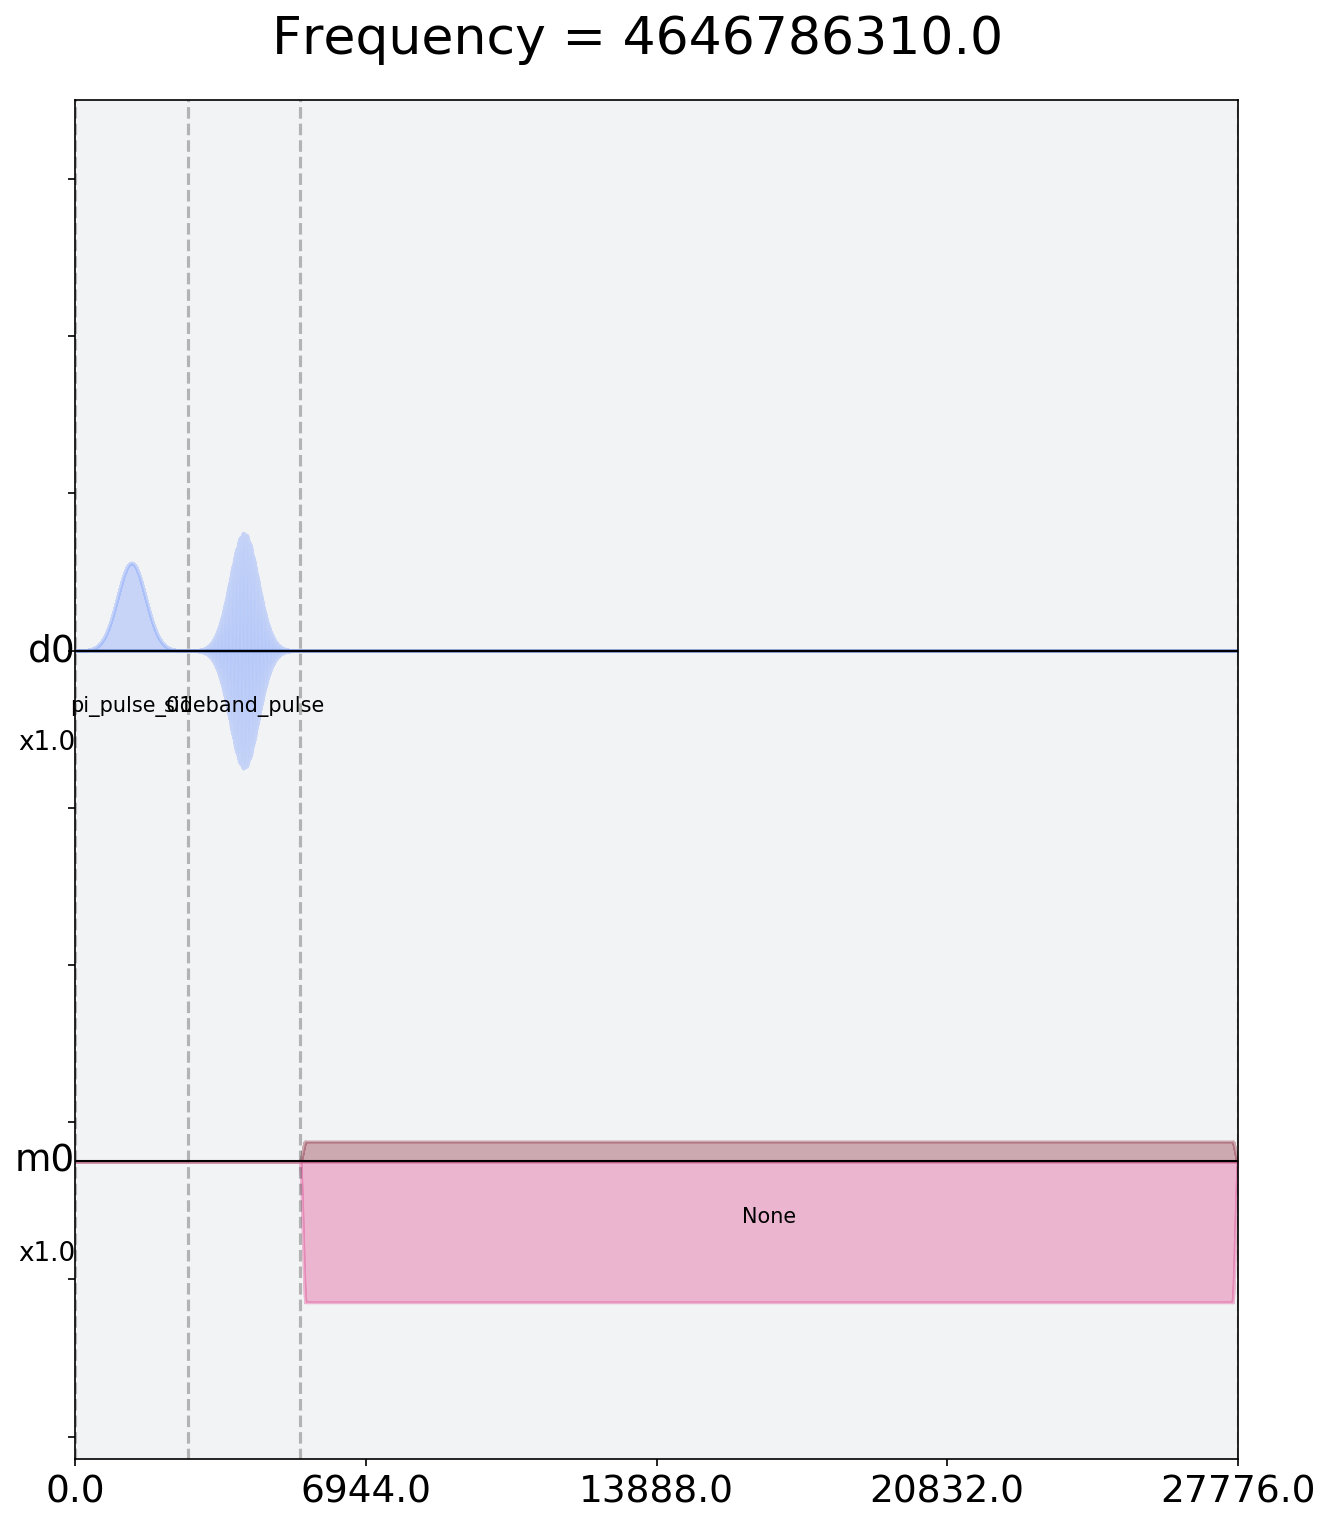

In [57]:
# smaller range refined sweep
num_freqs = 75

refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [58]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

IBMQBackendApiError: 'Error submitting job: "(\'Connection aborted.\', RemoteDisconnected(\'Remote end closed connection without response\'))"'

In [51]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

5f9690fc7b787b00147e8cbe
Job Status: job has successfully run


In [52]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [59]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

NameError: name 'refined_excited_freq_sweep_data' is not defined

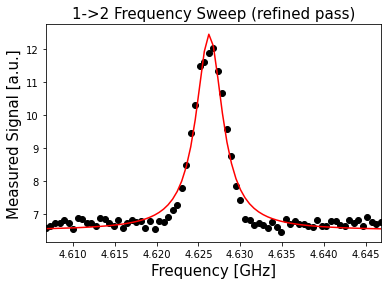

In [54]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [55]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

NameError: name 'refined_excited_sweep_fit_params' is not defined

In [62]:
qubit_12_freq = 4.6263002e9

### 2B. 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency (using the sideband method).

In [56]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [57]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [58]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [59]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [60]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

5f96940d00cb39001375c22e
Job Status: job has successfully run


In [61]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

We plot and fit our data as before.

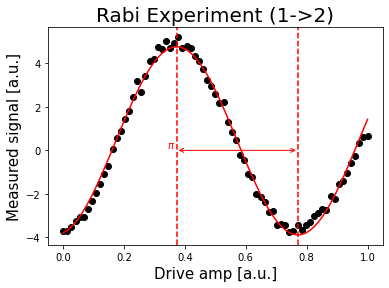

In [62]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [63]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6263002 GHz.
Pi Amplitude (1->2) = 0.37256049920143336


With this information, we can define our $1\rightarrow2$ $\pi$ pulse (making sure to add a sideband at the $1\rightarrow2$ frequency).

In [46]:
qubit_12_freq = 0.37256049920143336
pi_amp_12 = 0.37256049920143336

In [47]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

### 2C. Build the 0, 1, 2 discriminator <a id="builddiscrim012"></a>

Finally, we build our discriminator for the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states. The procedure is analogous to section [1](#discrim01), however now we add an additional schedule for the $|2\rangle$ state.

As a review, our three schedules are (again, recalling that our system starts in the $|0\rangle$ state): 
1. Measure the $|0\rangle$ state directly (obtain $|0\rangle$ centroid).
2. Apply $0\rightarrow1$ $\pi$ pulse and then measure (obtain $|1\rangle$ centroid).
3.  Apply $0\rightarrow1$ $\pi$ pulse, then $1\rightarrow2$ $\pi$ pulse, then measure (obtain $|2\rangle$ centroid).

In [48]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

We construct the program and plot the centroids in the IQ plane.

In [49]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [67]:
IQ_012_job = backend.run(IQ_012_program)

In [68]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

5f969656d3b8890012128a9e
Job Status: job has successfully run


In [69]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [50]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [51]:
x_min = -10
x_max = 20
y_min = -25
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)

NameError: name 'zero_data' is not defined

We now observe a third centroid corresponding to the $|2\rangle$ state. (Note: If the plot looks off, rerun the notebook)

With this data, we can build our discriminator. Again, we use `scikit.learn` and Linear Discriminant Analysis (LDA).

We begin by shaping the data for LDA.

In [72]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


Next, we split our training and testing data (again, half and half). The testing data is a vector containing an array of `0`'s (for the zero schedule, `1`'s (for the one schedule) and `2`'s (for the two schedule).

In [52]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


NameError: name 'IQ_012_data' is not defined

Finally, we set up our model and train it. The accuracy of our fit is printed.

In [74]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [75]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[0. 1. 1.]


In [76]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.826171875


The last step is to plot the separatrix. 

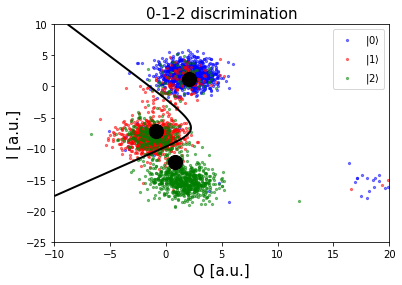

In [77]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

Now that we have 3 centroids, the separatrix is no longer a line, but rather a curve containing a combination of two lines. In order to discriminate between $|0\rangle$, $|1\rangle$ and $|2\rangle$ states, our model checks where the IQ point lies relative to the separatrix and classifies the point accordingly.

## 3. Discriminating the $|2\rangle$ and $|3\rangle$ states <a id="discrim23"></a>

### 3A. Computing the 2->3 frequency <a id="freq23"></a>

In [53]:
def create_23_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |2> state. 
    This allows us to obtain the 2->3 frequency. We get from the |1> to |2>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |2> to |3>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_23_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_23_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_23_pulse = apply_sideband(base_23_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_12, drive_chan)
        schedule |= pulse.Play(freq_sweep_23_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.2263002 GHz to 4.6563002 GHz using 75 frequencies. The drive power is 0.3.


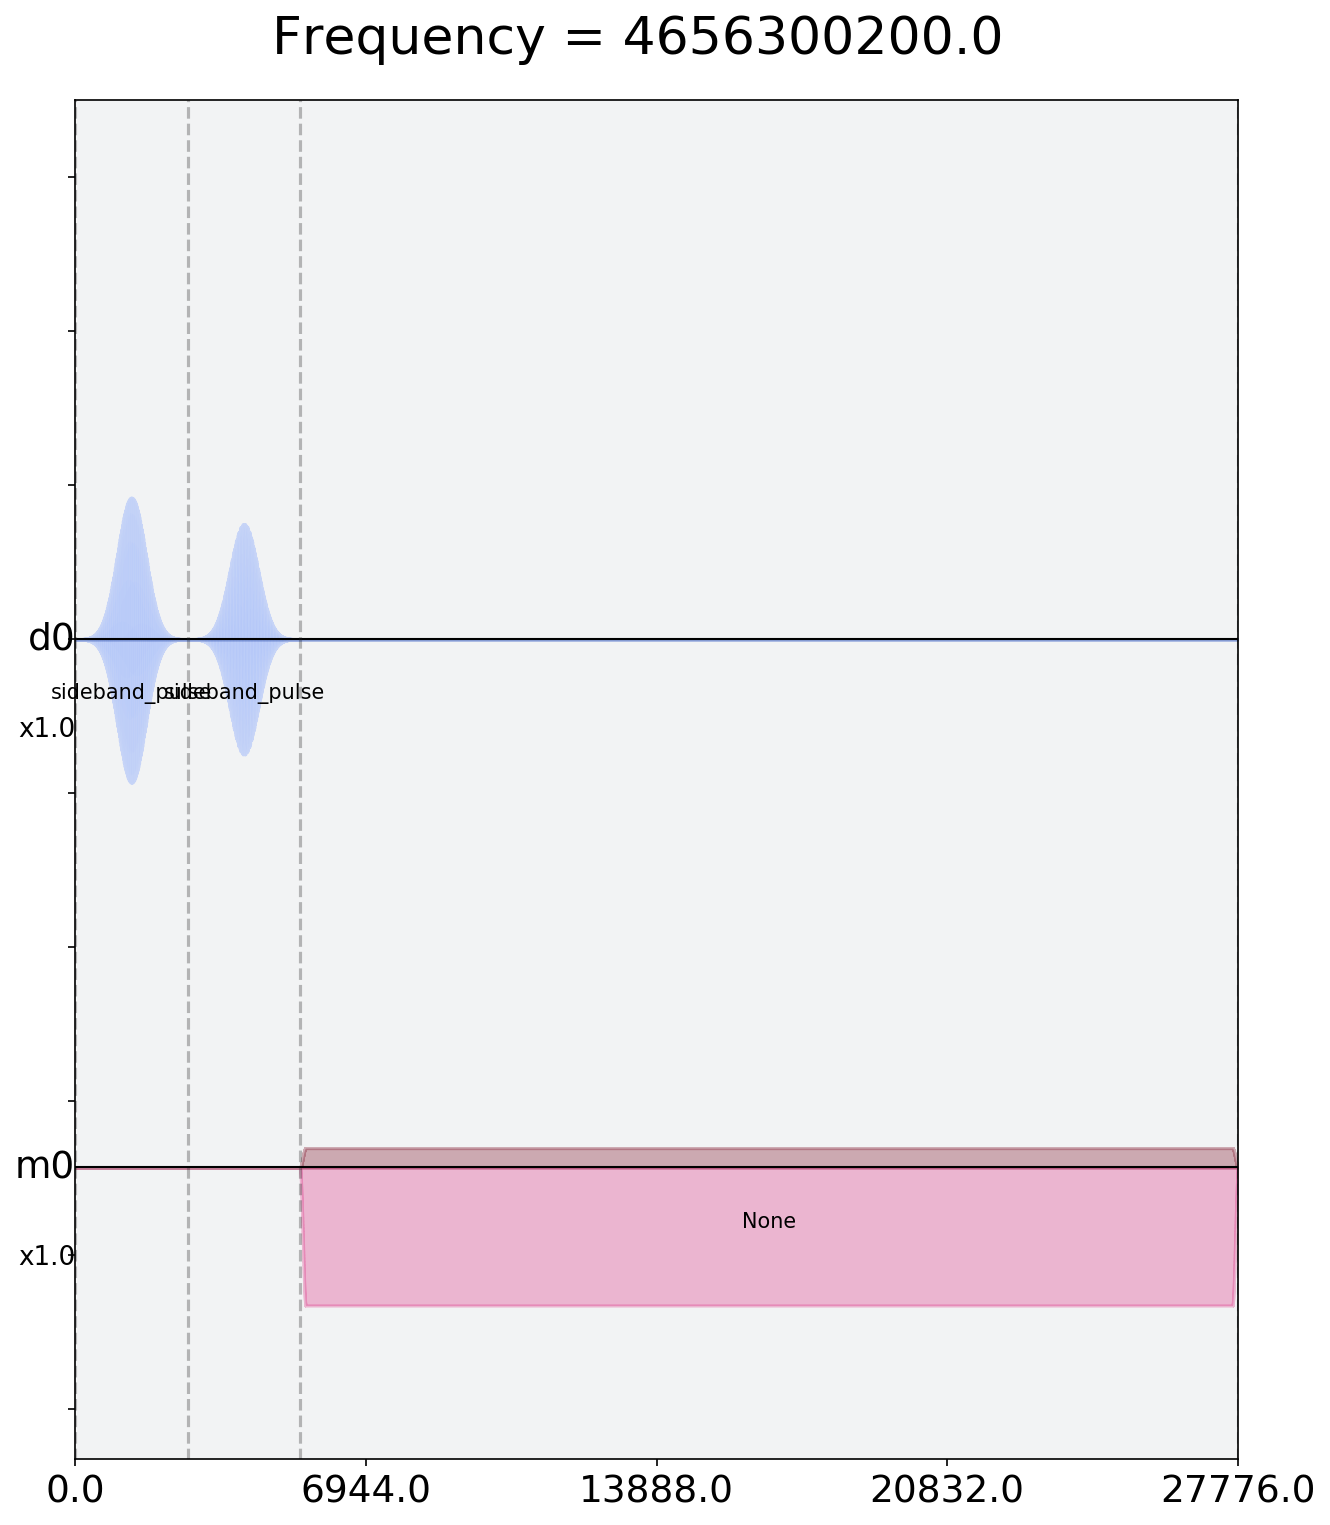

In [63]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
# excited_23_sweep_freqs = excited_sweep_freqs + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_23_sweep_freqs = qubit_12_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_23_freq_sweep_program = create_23_freq_sweep_program(excited_23_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [64]:
excited_23_freq_sweep_job = backend.run(excited_23_freq_sweep_program)

In [65]:
print(excited_23_freq_sweep_job.job_id())
job_monitor(excited_23_freq_sweep_job)

60723c6eb8a87570ccee8bf8
Job Status: job has successfully run


In [66]:
# Get job data (avg)
excited_23_freq_sweep_data = get_job_data(excited_23_freq_sweep_job, average=True)

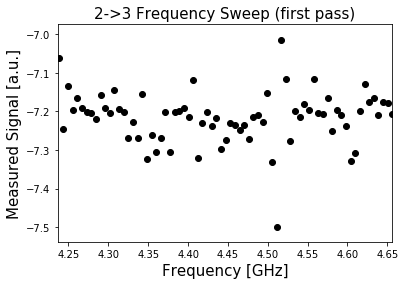

In [96]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_23_sweep_freqs/GHz, excited_23_freq_sweep_data, color='black')
plt.xlim([min(excited_23_sweep_freqs/GHz)+0.01, max(excited_23_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("2->3 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [91]:
print(np.argmax(np.real(excited_23_freq_sweep_data)))
# maxima_23 = rel_maxima(excited_sweep_freqs, np.real(excited_23_freq_sweep_data), 7.7)
maxima_23_index = np.argmax(np.real(excited_23_freq_sweep_data))
approx_23_freq = excited_sweep_freqs[maxima_23_index]
print(approx_23_freq)

50
4862157946.025663


The frequency sweep will go from 4.842157946025663 GHz to 4.882157946025663 GHz using 75 frequencies. The drive power is 0.3.


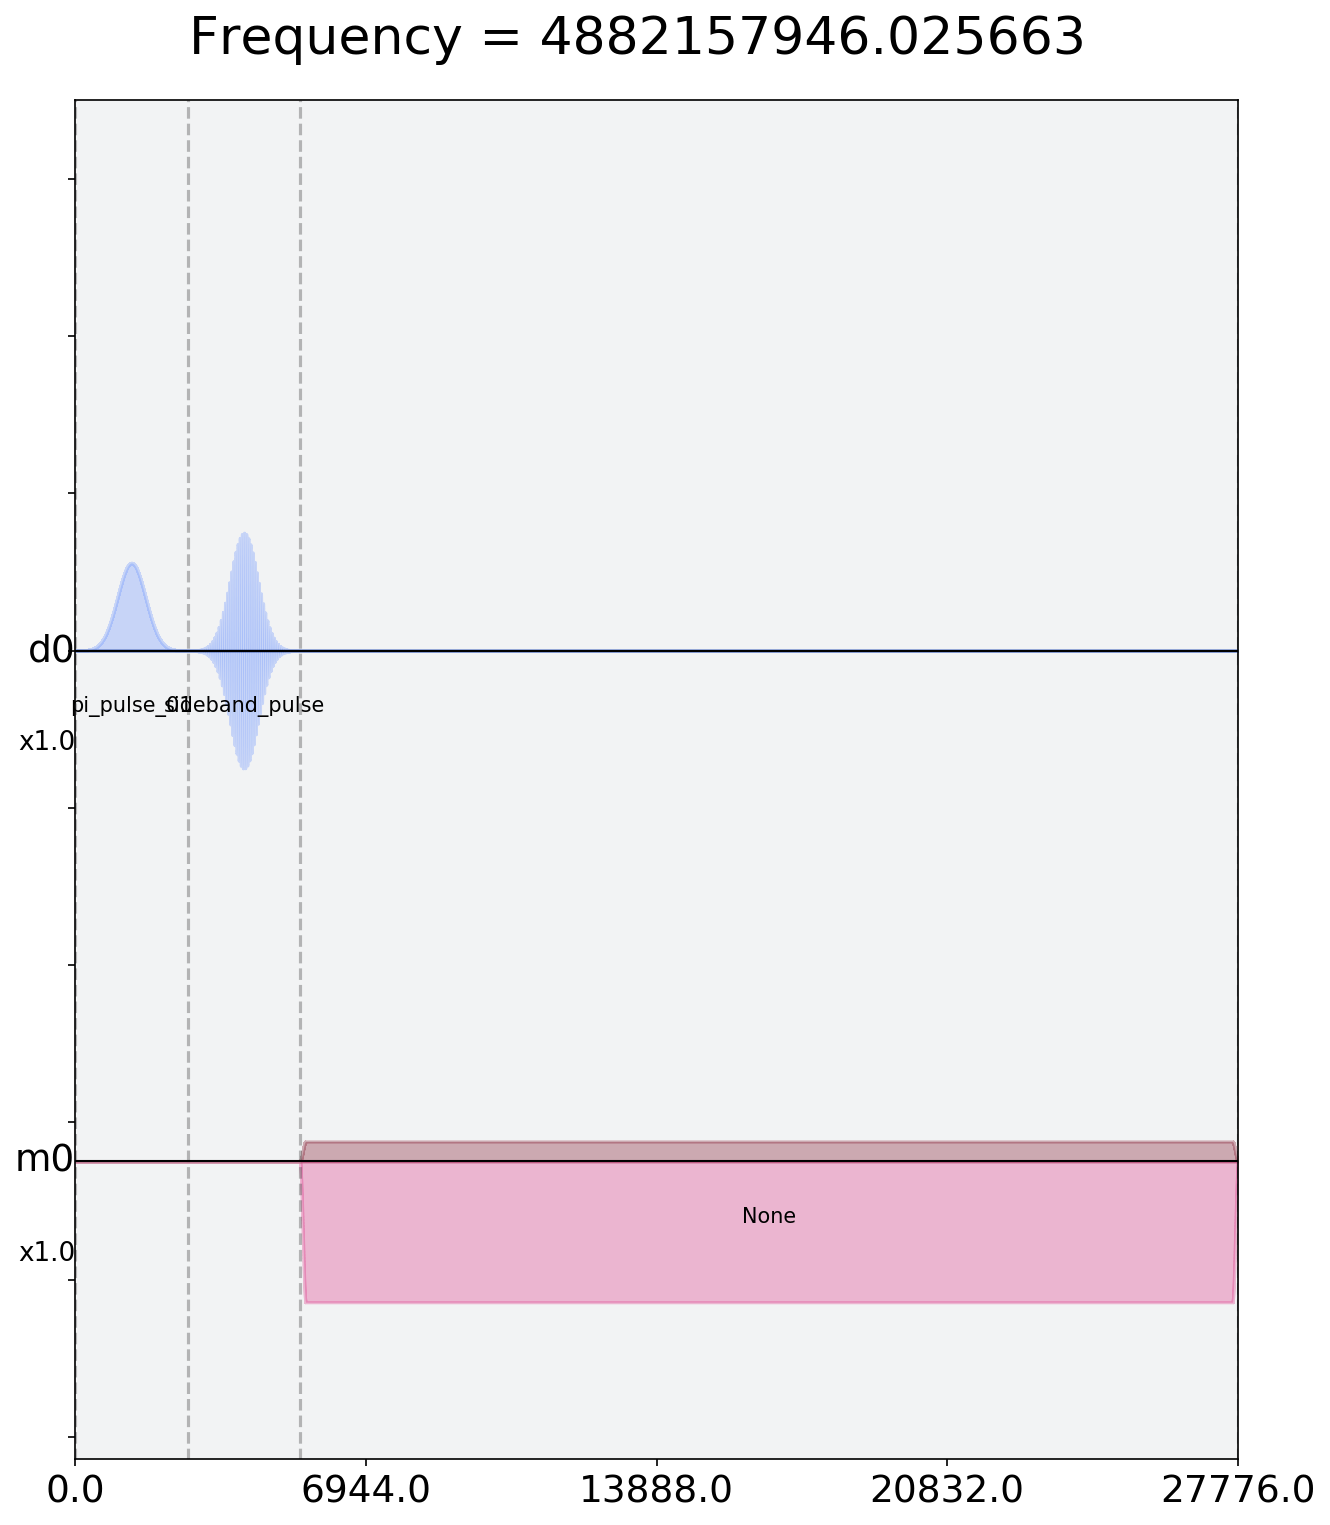

In [92]:
# smaller range refined sweep
num_freqs = 75

refined_excited_23_sweep_freqs = approx_23_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_23_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_23_sweep_freqs, drive_power=0.3)

In [94]:
refined_excited_23_freq_sweep_job = backend.run(refined_excited_23_freq_sweep_program)

In [95]:
print(refined_excited_23_freq_sweep_job.job_id())
job_monitor(refined_excited_23_freq_sweep_job)

60725420b08e3518d206728b
Job Status: job has successfully run


In [97]:
# Get the refined data (average)
refined_excited_23_freq_sweep_data = get_job_data(refined_excited_23_freq_sweep_job, average=True)

In [101]:
# do fit in Hz
(refined_excited_23_sweep_fit_params, 
 refined_excited_23_sweep_y_fit) = fit_function(refined_excited_23_sweep_freqs,
                                     refined_excited_23_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.862*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

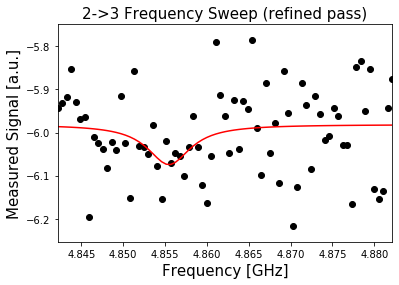

In [103]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_23_sweep_freqs/GHz, refined_excited_23_freq_sweep_data, color='black')
plt.plot(refined_excited_23_sweep_freqs/GHz, refined_excited_23_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_23_sweep_freqs/GHz), max(refined_excited_23_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("2->3 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [ ]:
'''
Note - this data points on this plot are widely varied and there may be a problem with the data I collected. 
However, I was not able to rerun due to time contraints and the fact that it took from half an hr to an hr to do one
job.
'''

In [106]:
_, qubit_23_freq, _, _ = refined_excited_23_sweep_fit_params
print(f"Our updated estimate for the 2->3 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 2->3 transition frequency is 4.6263002 GHz.


### 2B. 2->3 Rabi Experiment  <a id="rabi23"></a>

In [107]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [116]:
# Create schedule
rabi_23_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_23_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_23_pulse')
    # apply sideband at the 1->2 frequency
    rabi_23_pulse = apply_sideband(base_23_pulse, qubit_23_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_12, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_23_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_23_schedules.append(schedule)

In [117]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_23_expt_program = assemble(rabi_23_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [118]:
rabi_23_job = backend.run(rabi_23_expt_program)

In [119]:
print(rabi_23_job.job_id())
job_monitor(rabi_23_job)

60727706b8a87547deee8dd8
Job Status: job has successfully run


In [120]:
# Get the job data (average)
rabi_23_data = get_job_data(rabi_23_job, average=True)

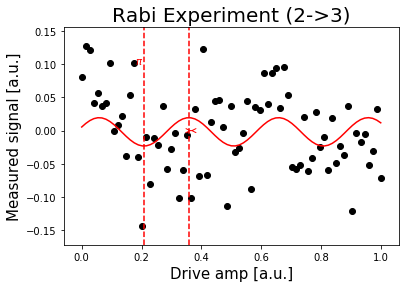

In [128]:
# Note: We only plot the real part of the signal.
rabi_23_data = np.real(baseline_remove(rabi_23_data))
(rabi_23_fit_params, 
 rabi_23_y_fit) = fit_function(drive_amps,
                            rabi_23_data, 
                            lambda x, A, B, drive_23_period, phi: (A*np.cos(2*np.pi*x/drive_23_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_23_data, color='black')
plt.plot(drive_amps, rabi_23_y_fit, color='red')

drive_23_period = rabi_23_fit_params[2]
# account for phi in computing pi amp
pi_amp_23 = (drive_23_period/2/np.pi) *(np.pi+rabi_23_fit_params[3])

plt.axvline(pi_amp_23, color='red', linestyle='--')
plt.axvline(pi_amp_23+drive_23_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_23+drive_23_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_23-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (2->3)', fontsize=20)
plt.show()

In [ ]:
'''
Note - again this data points on this plot are widely varied and there may be a problem with the data I collected. 
However, I was also not able to rerun due to time contraints and the fact that it took from half an hr to an hr to do one
job. The plot does have a sinusoidal fit so it looks correct in that respect.
'''

In [125]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_23_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (2->3) = {pi_amp_23}")

Our updated estimate for the 1->2 transition frequency is 4.8554629 GHz.
Pi Amplitude (2->3) = 0.2082969544662281


In [126]:
pi_pulse_23 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_23')
# make sure this pulse is sidebanded
pi_pulse_23 = apply_sideband(pi_pulse_23, qubit_23_freq)

In [154]:
print(pi_pulse_23)
print(qubit_23_freq)

Waveform(array([-0.00000000e+00+0.j, -6.02737887e-07+0.j, -1.67486705e-06+0.j, ...,
       -4.58208868e-06+0.j, -2.91708168e-06+0.j, -1.49336921e-06+0.j]), name='sideband_pulse')
4855462862.054147


### 2C. Build the 0, 1, 2, 3 discriminator <a id="builddiscrim023"></a>

In [132]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

# Excited state schedule
three_schedule = pulse.Schedule(name="three schedule")
three_schedule |= pulse.Play(pi_pulse_01, drive_chan)
three_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
three_schedule |= pulse.Play(pi_pulse_23, drive_chan) << three_schedule.duration
three_schedule |= measure << three_schedule.duration

In [138]:
# Assemble the schedules into a program
IQ_0123_program = assemble([zero_schedule, one_schedule, two_schedule, three_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 4)

In [139]:
IQ_0123_job = backend.run(IQ_0123_program)

In [140]:
print(IQ_0123_job.job_id())
job_monitor(IQ_0123_job)

60728fb557095c69cc7d85a9
Job Status: job has successfully run


In [141]:
# Get job data (single); split for zero, one and two
IQ_0123_data = get_job_data(IQ_0123_job, average=False)
zero_data = IQ_0123_data[0]
one_data = IQ_0123_data[1]
two_data = IQ_0123_data[2]
three_data = IQ_0123_data[3]

In [151]:
def IQ_0123_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')
    # three data plotted in purple
    plt.scatter(np.real(three_data), np.imag(three_data), 
                    s=5, cmap='viridis', c='purple', alpha=0.5, label=r'$|3\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_three = np.mean(three_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_three), np.imag(mean_three), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    print(x_min, x_max)
    print(y_min,y_max)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2-3 discrimination", fontsize=15)

-30 -10
-15 5


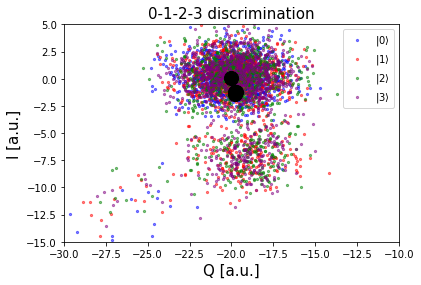

In [152]:
x_min = -30
x_max = -10
y_min = -15
y_max = 5
IQ_0123_plot(x_min, x_max, y_min, y_max)

## 3. References <a id="refs"></a>

1. D. C. McKay, T. Alexander, L. Bello, M. J. Biercuk, L. Bishop, J. Chen, J. M. Chow, A. D. C ́orcoles, D. Egger, S. Filipp, J. Gomez, M. Hush, A. Javadi-Abhari, D. Moreda, P. Nation, B. Paulovicks, E. Winston, C. J. Wood, J. Wootton, and J. M. Gambetta, “Qiskit backend specifications for OpenQASM and OpenPulse experiments,” 2018, https://arxiv.org/abs/1809.03452.
2. Krantz, P. et al. “A Quantum Engineer’s Guide to Superconducting Qubits.” Applied Physics Reviews 6.2 (2019): 021318, https://arxiv.org/abs/1904.06560.
3. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011, https://scikit-learn.org/stable/modules/lda_qda.html#id4.

In [78]:
import qiskit.tools.jupyter
%qiskit_version_table